## Tracking a force-driven object in 1D

### Model:

our state-space includes force $f$, position $x$ and velocity $\dot{x}$,

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = f \\  \mathbf{x}_2 = x \\ \mathbf{x}_3 =\dot{x} \end{pmatrix}  
$$

we define a constant torque model, 

$$
\mathbf{\dot{x}} = \begin{pmatrix} \mathbf{\dot{x}}_1 = \dot{f} \\  \mathbf{\dot{x}}_2 =\dot{x} \\ \mathbf{\dot{x}}_3 =\ddot{x}  \end{pmatrix}  = \begin{pmatrix} 0 \\  \mathbf{x}_3 \\ \frac{1}{m}\mathbf{x}_1  \end{pmatrix} := a(\mathbf{x})
$$

In matrix form, for Kalman Filtering and smoothing:
$$
\mathbf{\dot{x}} = \begin{pmatrix} 0 & 0 & 0 \\  0 & 0 & 1 \\ \frac{1}{m} & 0 & 0 \\ \end{pmatrix} := a(\mathbf{x})
$$

In principle, $a(\mathbf{x})$ will be non-linear with an inverted inertia tensor a function of $\mathbf{x}$.

Adding noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} I \\ 0 \\ 0 \end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ 0 \\ 0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \sigma \\ \sigma \end{pmatrix} \nu_t
 $$
 
where we introduce $\sigma<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a)\mathbf{x}_t), \text{diag}(\Delta{t}^2,\sigma, \sigma))
$$

ToDo: square $\sigma$ in the same form inside cov mat.

$$
p(x_{1:T}|y_{1:T})
$$

In [1]:
import os
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test'

In [2]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state

In [3]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import force_model_moving_obj_1D # the model script -- distribution objects are defined there

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [5]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

plot_folder = 'forced_mass_1D_plots'

In [59]:
# define global params which we're not ineferring 
transition_force_scale = 2 # 2 was fine
emission_scale = 0.3 #0.5
# proposal_scale_0 = 1
# proposal_scale_t = 0.1
initial_loc = 0.0 # inside model script it is expanded to 3d
initial_scale = 1 # same here 
# define train/infer params
num_timesteps = 100
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10 # NOTE - if manual data set, press 1
num_iterations = 500
num_particles = 200
dt = 0.03 # 
transition_aux_scale = np.sqrt(((transition_force_scale * dt)**2)/5)
print(transition_aux_scale)
m = 0.75 #  just made it up

0.026832815729997475


In [60]:
initial = force_model_moving_obj_1D.Initial(initial_loc, initial_scale)
transition = force_model_moving_obj_1D.Transition(\
     m, dt, transition_force_scale, transition_aux_scale)
emission = force_model_moving_obj_1D.Emission(emission_scale)

In [61]:
# define proposal here
'''we are using the parameters of the initial and transition.'''
proposal = force_model_moving_obj_1D.Bootstrap_Proposal(
                m, dt, initial_scale, initial_loc, 
            transition_force_scale, transition_aux_scale)

In [62]:
np.random.seed(0)
torch.manual_seed(0)

In [63]:
# sim_lats, sim_observs = force_model_moving_obj_1D.sim_data(dt, num_timesteps, m, 0.2, 5.0,
#              0.7, 1/2*np.pi, emission_scale, False)
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [64]:
# simulate from the model
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 3])
torch.Size([10, 1])


In [65]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

torch.Size([10, 3, 100])
torch.Size([10, 1, 100])


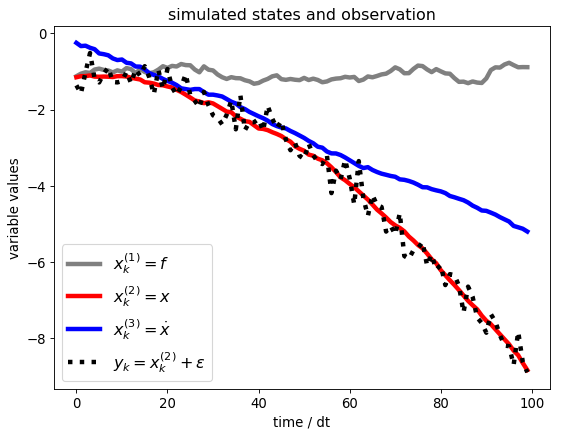

In [66]:
ind_in_batch = 0 # could be between 0 and batch_size-1
plt.plot(lat_data[ind_in_batch,0,:].detach().numpy(), 'gray', 
         label="$x_k^{(1)} = f$");
plt.plot(lat_data[ind_in_batch,1,:].detach().numpy(), 'red', 
         label = "$x_k^{(2)} = x$");
plt.plot(lat_data[ind_in_batch,2,:].detach().numpy(), 'blue', 
         label = "$x_k^{(3)} = \dot{x}$");
plt.plot(sim_data[ind_in_batch,0,:].detach().numpy(), 'black', 
          label = "$y_k= x_k^{(2)} + \epsilon$", linestyle = ':');#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('simulated states and observation')
plt.ylabel('variable values')
plt.xlabel('time / dt')
plt.legend();
plt.savefig(plot_folder + '/sim_data.png')

In [48]:
inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=test_inference_num_particles,
            return_log_weights=True,
        )

In [49]:
# extract mean and variance of the latents
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [50]:
# Note: we extracted sim_data and lat_data above
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [51]:
# transform to numpy arrays once
sim_data_np = sim_data.detach().numpy()
lat_data_np = lat_data.detach().numpy()
smooth_mean_np = smooth_mean.detach().numpy()
smooth_var_np = smooth_var.detach().numpy()

In [52]:
smooth_mean_np.shape

(10, 3, 100)

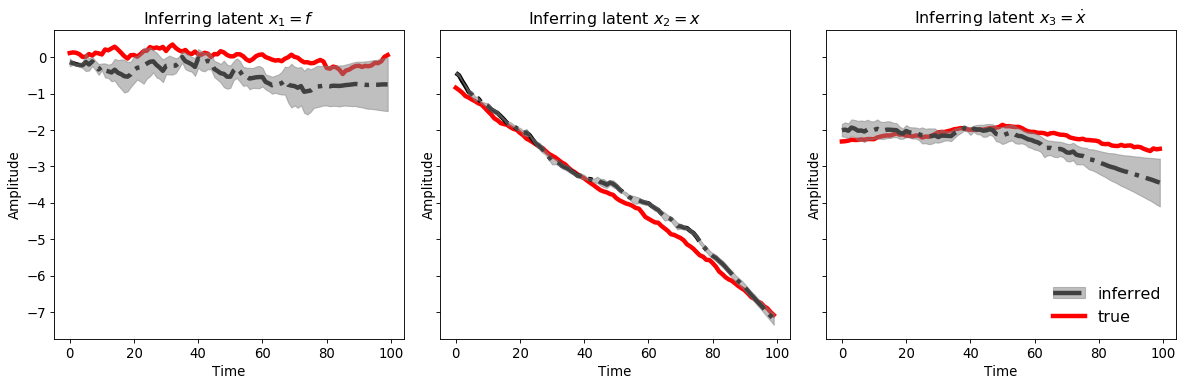

In [68]:
from arm_models import arm_utils
ind_in_batch = 7
fig, axs = plt.subplots(1,3, figsize = (15,5), sharey=True)
plt_leg = False
for i in range(smooth_mean_np.shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
        
    arm_utils.plot_posterior_trace(post_mean = smooth_mean_np[ind_in_batch,i,: ], 
                     post_var = np.sqrt(smooth_var_np[ind_in_batch,i,: ]), 
                     data_vec = lat_data[ind_in_batch,i,:].\
                    detach().numpy(), 
                     alpha = 0.5, plot_legend=plt_leg, 
                     plot_uncertainty=True, plot_true_data=True, 
                     legends_list = ["inferred",
                                        "true"], 
                     legend_loc = "lower right", title = "Inferring latent " + label , 
                     xlabel = 'Time', ylabel = 'Amplitude', fig_fullname = None, 
                     ax = axs[i]);
fig.tight_layout()
plt.savefig(plot_folder+'/BPF_infer_latents.png')

In [22]:
log_weights =  torch.cat([weights.unsqueeze(-1) for
                           weights in inference_result["log_weights"]],
                         dim=2)
print(log_weights.shape)
#ws = log_weights[ind_in_batch,:,:].detach().numpy()
#print(ws.shape)

torch.Size([10, 1000, 100])


In [23]:
ESS = np.zeros(ws.shape[1])
for i in range(ws.shape[1]):
    ESS[i] = statistics.ess(log_weights[ind_in_batch,:,i])

NameError: name 'ws' is not defined

In [206]:
# for the case of a single batch
# ESS = np.zeros(num_timesteps)
# for i in range(len(inference_result["log_weights"])):
#     ESS[i] = statistics.ess(inference_result["log_weights"][i])

In [24]:
plt.plot(ESS)
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % test_inference_num_particles);
plt.savefig(plot_folder+'/ESS.png')

NameError: name 'ESS' is not defined

In [208]:
# pred = smooth_mean_np[ind_in_batch,1,:-2] + \
#     dt * smooth_mean_np[ind_in_batch,2,:-2]
# plt.plot(smooth_mean_np[ind_in_batch, 1, 1:], "--", 
#          label = r"$\hat{x}_2(k)$")
# plt.plot(pred, ":", label = r"$\hat{x}_{2}(k-1) + \Delta{t}\hat{x}_{3}(k-1)$")
# plt.plot(lat_data_np[ind_in_batch, 1, 1:], "--",
#         label = r"$x_2(k)$")
# # plt.plot(sim_data_np[ind_in_batch, 0, 1:], "+",
# #         label = r"$y(k)$")
# pred_sim = lat_data_np[ind_in_batch,1,:-2] + \
#     dt * lat_data_np[ind_in_batch,2,:-2]
# plt.plot(pred_sim, ":",label = r"$x_{2}(k-1) + \Delta{t}x_{3}(k-1)$")
# plt.title('Check computation of $x_2$');
# plt.legend();

In [209]:
# plt.title('last steps in $x_2$')
# plt.plot(lat_data_np[ind_in_batch, 1, -20:], label = 'true')
# plt.plot(smooth_mean_np[ind_in_batch, 1, -20:], ":", label = 'recovered')
# plt.legend()

In [210]:
# pred = smooth_mean_np[ind_in_batch,2,:-2] + \
#     dt * ((1/m)*smooth_mean_np[ind_in_batch,0,:-2])
# plt.plot(smooth_mean_np[ind_in_batch, 2, 1:], "--", 
#          label = r"$\hat{x}_3(k)$")
# plt.plot(pred, ":", 
#          label = r"$\hat{x}_{3}(k-1) + \Delta{t}\frac{1}{m}\hat{x}_{1}(k-1)$")
# plt.plot(lat_data_np[ind_in_batch, 2, 1:], "--",
#         label = r"$x_3(k)$")
# # plt.plot(sim_data_np[ind_in_batch, 0, 1:], "+",
# #         label = r"$y(k)$")
# pred_sim = lat_data_np[ind_in_batch,2,:-2] + \
#     dt * ((1/m)*lat_data_np[ind_in_batch,0,:-2])
# plt.plot(pred_sim, ":",label = r"$x_{3}(k-1) + \Delta{t}\frac{1}{m}x_{1}(k-1)$")
# plt.title('Check computation of $x_3$');
# plt.legend();

In [213]:
ESS = statistics.ess(inference_result['log_weight'])
print('effective sample size at last time point = %.2f' % ESS.detach().numpy())

effective sample size at last time point = 918.91


In [216]:
measure_reshaped = sim_data_np.reshape(100,1)
print(measure_reshaped[:3,0])
print(sim_data_np[0,0,:3])
print(measure_reshaped.shape)

[-0.12289952 -0.1449129  -0.41572252]
[-0.12289952 -0.1449129  -0.41572252]
(100, 1)


In [217]:
A = np.array([[0.0, 0.0, 0.0],[0.0,0.0,1.0],[1.0/m, 0.0, 0.0]])
transition_mat = np.eye(3) + dt* A
transition_mat

array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.03],
       [0.04, 0.  , 1.  ]])

In [218]:
transition_cov = np.diag([(dt**2)*transition_force_scale**2,
                         transition_aux_scale**2,
                        transition_aux_scale**2])

In [219]:
transition_cov

array([[0.0036 , 0.     , 0.     ],
       [0.     , 0.00072, 0.     ],
       [0.     , 0.     , 0.00072]])

In [221]:
initial_state_mean = np.ones(3)* initial_loc
initial_state_covariance = np.eye(3) * initial_scale**2
print(initial_state_covariance)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [222]:
observation_cov = emission_scale**2

In [223]:
from pykalman import KalmanFilter
import numpy as np
kf = KalmanFilter(initial_state_mean= initial_state_mean,
                  initial_state_covariance= initial_state_covariance,
                transition_matrices = transition_mat, 
                  transition_covariance= transition_cov,
                  observation_matrices = observation_mat,
                 observation_covariance= observation_cov)

In [224]:
measurements = measure_reshaped # 3 observations
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

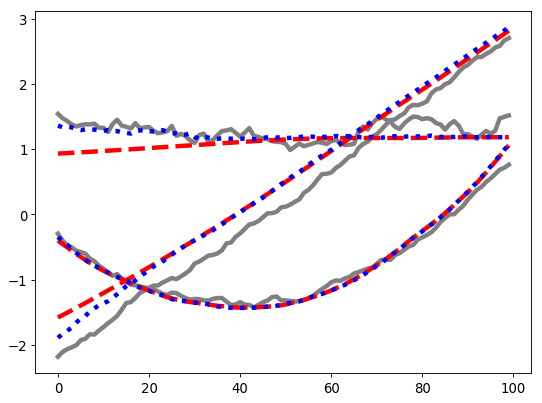

In [225]:
plt.plot(lat_data_np.reshape(3,100).T, color = 'gray', label = "ground-truth");
plt.plot(smoothed_state_means, color = 'red', linestyle = 'dashed', label = 'K-smoother');
plt.plot(smooth_mean_np.reshape(3,100).T, color = 'blue', 
         linestyle = 'dotted', label = 'SMC bootstrap')
#plt.legend(labels = ["ground-truth",'K-smoother', 'SMC bootstrap'])

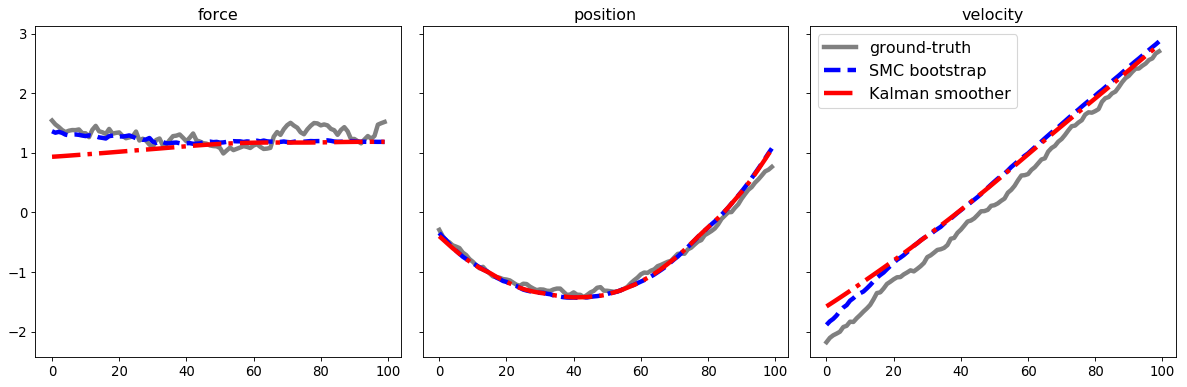

In [227]:
from arm_models import arm_utils
ind_in_batch = 0
fig, axs = plt.subplots(1,3, figsize = (15,5), sharey=True)
titles = ['force', 'position', 'velocity']
plt_leg = False
for i in range(smooth_mean_np.shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(lat_data_np[ind_in_batch,i,:], color = 'gray', label = "ground-truth")
    axs[i].plot(smooth_mean_np[ind_in_batch,i,:], color = 'blue', linestyle = 'dashed',
                label = 'SMC bootstrap')
    axs[i].plot(smoothed_state_means[:,i], color = 'red', linestyle = 'dashdot', 
                label = 'Kalman smoother');
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title(titles[i])

axs[2].legend()
fig.tight_layout()
plt.savefig(plot_folder+'/method_comparison_no_filt.png')